# Kratos example

In [10]:
from probabilistic_library import ReliabilityProject, ReliabilityMethod, DistributionType, CombineProject, CombineType, CombinerMethod, CompareType
from probabilistic_library import UncertaintyProject, UncertaintyMethod, Stochast

### Model

In [11]:
from run_kratos_quay_wall import zfuncwrapper_linear

### Variables

In [12]:
def define_project_variables(project, sheetpile_thickness):
    use_correlations = False
    project.variables["geo_young_modulus"].is_array = True
    if use_correlations:
        project.variables["geo_young_modulus"].array_size = 2
        maxNrClays = 0
    else:
        project.variables["geo_young_modulus"].array_size = 7
        maxNrClays = 3

    for i in range(project.variables["geo_young_modulus"].array_size):
        young_modulus = Stochast()
        if i <= maxNrClays: # Clays with low-medium plasticity, medium
            young_modulus.distribution = DistributionType.uniform
            young_modulus.minimum = 5E6
            young_modulus.maximum = 8E6
        else: # Sand, uniform, medium
            young_modulus.distribution = DistributionType.deterministic
            young_modulus.mean = 40E6
        project.variables["geo_young_modulus"].array_variables.append(young_modulus)

    project.variables["interface_stiffness"].distribution = DistributionType.deterministic
    project.variables["interface_stiffness"].is_array = True
    project.variables["interface_stiffness"].array_size = 6
    project.variables["interface_stiffness"].mean = 10**11 # value checked

    project.variables["sheetpile_young_modulus"].distribution = DistributionType.deterministic
    project.variables["sheetpile_young_modulus"].is_array = True
    project.variables["sheetpile_young_modulus"].array_size = 1
    project.variables["sheetpile_young_modulus"].mean = 200e9 # value checked

    project.variables["sheetpile_poisson_ratio"].distribution = DistributionType.deterministic
    project.variables["sheetpile_poisson_ratio"].is_array = True
    project.variables["sheetpile_poisson_ratio"].array_size = 1
    project.variables["sheetpile_poisson_ratio"].mean = 0.0 # value checked

    project.variables["sheetpile_thickness"].distribution = DistributionType.deterministic
    project.variables["sheetpile_thickness"].is_array = True
    project.variables["sheetpile_thickness"].array_size = 1
    project.variables["sheetpile_thickness"].mean = sheetpile_thickness

    return project

### Uncertainty analysis

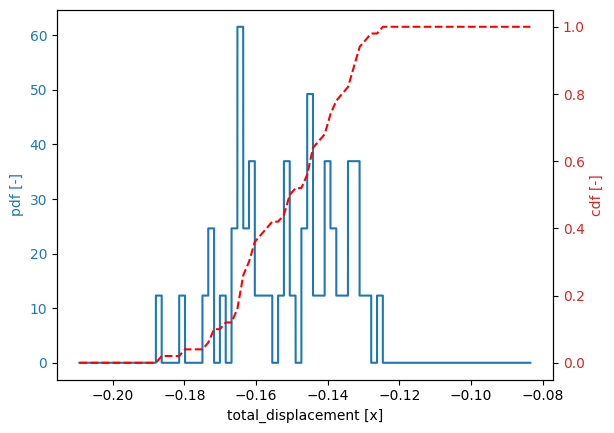

In [ ]:
project = UncertaintyProject()
wrapper = zfuncwrapper_linear(output_stage_number = 3, clean_up = True)
project.model = wrapper.total_displacement

sheetpile_thickness = 0.015
project = define_project_variables(project, sheetpile_thickness)

project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
project.settings.variation_coefficient = 0.02
project.settings.minimum_samples = 50
project.settings.maximum_samples = 100
project.settings.save_convergence = True
project.settings.save_realizations = True

project.run()

project.stochast.plot()

### Reliability analysis, prior

Expected sheet pile thickness in year 2075 is 0.015 m

Reliability (FORM)
 Reliability index = 0.7892
 Probability of failure = 0.215
 Convergence = 0.008235 (converged)
 Model runs = 25
Alpha values:
 geo_young_modulus[0]: alpha = 0.05116, x = 6.452e+06
 geo_young_modulus[1]: alpha = 0.9641, x = 5.67e+06
 geo_young_modulus[2]: alpha = -0.0178, x = 6.517e+06
 geo_young_modulus[3]: alpha = 0.2598, x = 6.256e+06
 geo_young_modulus[4]: alpha = 0, x = 4e+07
 geo_young_modulus[5]: alpha = 0, x = 4e+07
 geo_young_modulus[6]: alpha = 0, x = 4e+07
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[1]: alpha = 0, x = 1e+11
 interface_stiffness[2]: alpha = 0, x = 1e+11
 interface_stiffness[3]: alpha = 0, x = 1e+11
 interface_stiffness[4]: alpha = 0, x = 1e+11
 interface_stiffness[5]: alpha = 0, x = 1e+11
 sheetpile_young_modulus[0]: alpha = 0, x = 2e+11
 sheetpile_poisson_ratio[0]: alpha = 0, x = 0
 sheetpile_thickness[0]: alpha = 0, x = 0.015



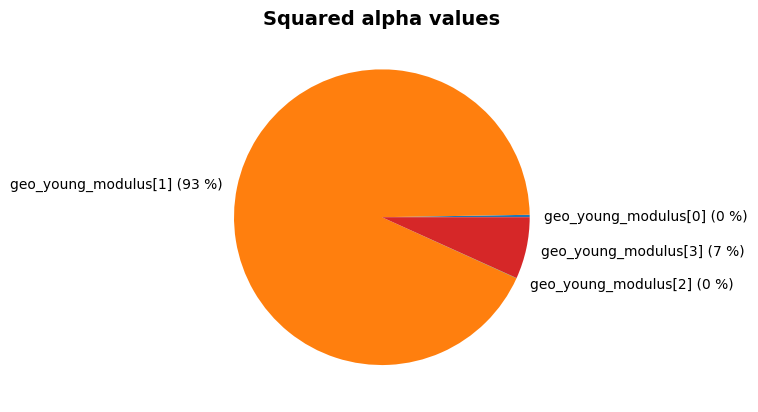

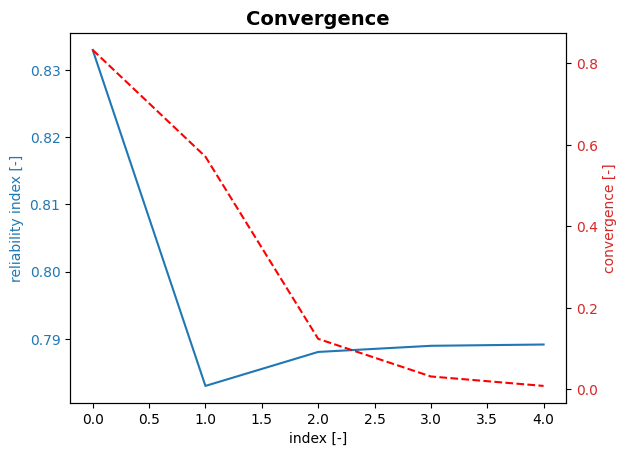

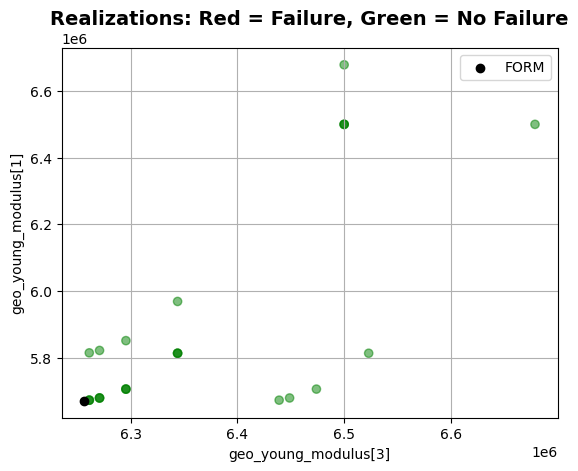

In [16]:
project = ReliabilityProject()
wrapper = zfuncwrapper_linear(output_stage_number = 3, clean_up = True)
project.model = wrapper.total_displacement

sheetpile_thickness = 0.015
project = define_project_variables(project, sheetpile_thickness)

project.limit_state_function.parameter = project.model.output_parameters[0]
project.limit_state_function.compare_type = CompareType.less_than
project.limit_state_function.critical_value = -0.17

project.settings.reliability_method = ReliabilityMethod.form
project.settings.epsilon_beta = 0.02
project.settings.maximum_iterations = 50
project.settings.save_convergence = True
project.settings.save_realizations = True

project.run()

project.design_point.print()
project.design_point.plot_alphas()
project.design_point.plot_convergence()
project.design_point.plot_realizations()

prior = project.design_point

### Survived event

Sheet pile thickness in 2025 is 0.025 and the total displacement is less than the critical value of -0.17 m

Reliability (FORM)
 Reliability index = -0.6811
 Probability of failure = 0.7521
 Convergence = 0.007713 (converged)
 Model runs = 25
Alpha values:
 geo_young_modulus[0]: alpha = -0.01621, x = 6.487e+06
 geo_young_modulus[1]: alpha = -0.9784, x = 5.758e+06
 geo_young_modulus[2]: alpha = -0.0264, x = 6.478e+06
 geo_young_modulus[3]: alpha = -0.2042, x = 6.334e+06
 geo_young_modulus[4]: alpha = 0, x = 4e+07
 geo_young_modulus[5]: alpha = 0, x = 4e+07
 geo_young_modulus[6]: alpha = 0, x = 4e+07
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[1]: alpha = 0, x = 1e+11
 interface_stiffness[2]: alpha = 0, x = 1e+11
 interface_stiffness[3]: alpha = 0, x = 1e+11
 interface_stiffness[4]: alpha = 0, x = 1e+11
 interface_stiffness[5]: alpha = 0, x = 1e+11
 sheetpile_young_modulus[0]: alpha = 0, x = 2e+11
 sheetpile_poisson_ratio[0]: alpha = 0, x = 0
 sheetpile_thickness[0]: alpha = 0, x = 0.025



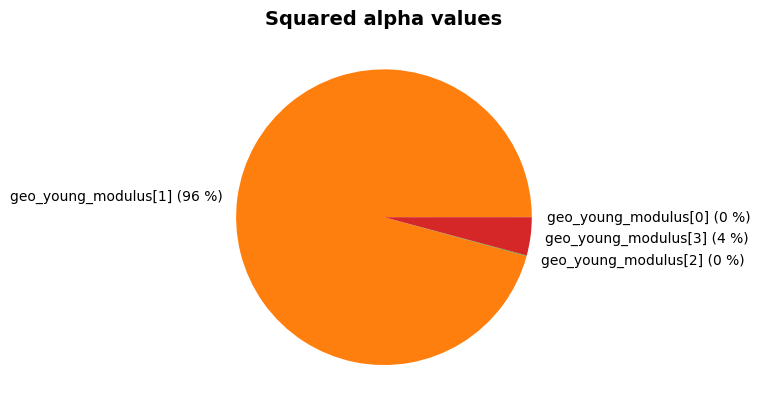

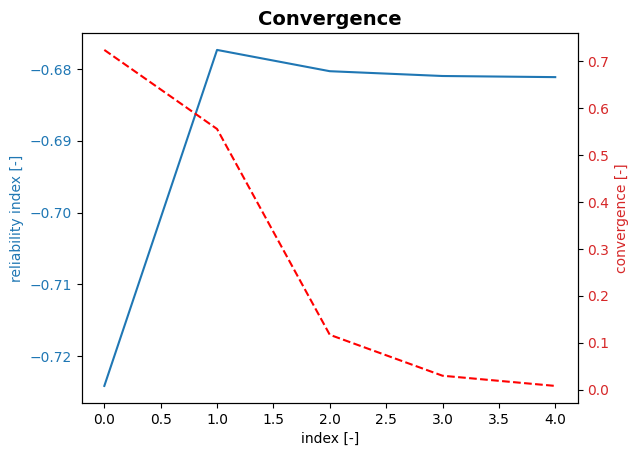

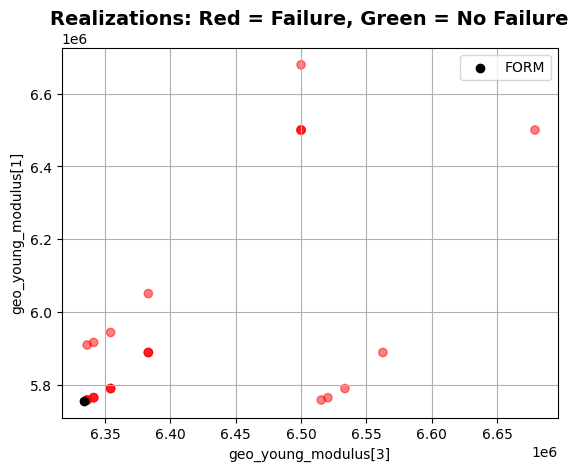

In [17]:
sheetpile_thickness = 0.025
define_project_variables(project, sheetpile_thickness)

project.limit_state_function.parameter = project.model.output_parameters[0]
project.limit_state_function.compare_type = CompareType.greater_than
project.limit_state_function.critical_value = -0.17

project.settings.reliability_method = ReliabilityMethod.form
project.settings.epsilon_beta = 0.02
project.settings.maximum_iterations = 50
project.settings.save_convergence = True
project.settings.save_realizations = True

project.run()

project.design_point.print()
project.design_point.plot_alphas()
project.design_point.plot_convergence()
project.design_point.plot_realizations()

survived_event = project.design_point

### Combined probability

In [18]:
combine_project = CombineProject()

combine_project.design_points.append(prior)
combine_project.design_points.append(survived_event)

combine_project.settings.combine_type = CombineType.parallel
combine_project.settings.combiner_method = CombinerMethod.hohenbichler_form

combine_project.run()

combine_project.design_point.print()

comb = combine_project.design_point

Reliability:
 Reliability index = 2.934
 Probability of failure = 0.001671
 Model runs = 0
Alpha values:
 geo_young_modulus[0]: alpha = 0.4177, x = 5.33e+06
 geo_young_modulus[1]: alpha = 0.1787, x = 5.9e+06
 geo_young_modulus[2]: alpha = -0.5121, x = 7.801e+06
 geo_young_modulus[3]: alpha = 0.7289, x = 5.049e+06
 geo_young_modulus[4]: alpha = 0, x = 4e+07
 geo_young_modulus[5]: alpha = 0, x = 4e+07
 geo_young_modulus[6]: alpha = 0, x = 4e+07
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[0]: alpha = 0, x = 1e+11
 interface_stiffness[0]: alpha = 0, x = 1e+11
 sheetpile_young_modulus[0]: alpha = 0, x = 2e+11
 sheetpile_poisson_ratio[0]: alpha = 0, x = 0
 sheetpile_thickness[0]: alpha = 0, x = 0.025



### Reliability, posterior

In [19]:
prob_posterior = comb.probability_failure/survived_event.probability_failure

print(prob_posterior)

0.002222376288286381
